# fitting annihilation msr timeseries
Tim Tyree<br>
7.5.2022

In [2]:
from IPython.display import clear_output
clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [12]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# load data

In [4]:
#load spiral tip range time series from cache
#######################
# Luo-Rudy
#######################
#WJ's data for LR model (200x200)
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_range_timeseries.pkl'
# #my data for LR model (200x200) diffCoeff=0.001
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'
#my data for LR model (200x200) diffCoeff=0.0005
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_range_timeseries.pkl'

#######################
# Fenton-Karma
#######################

# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_range_timeseries.pkl'
# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_range_timeseries.pkl'
# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_range_timeseries.pkl'
# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilation_range_timeseries.pkl'



data_lst=load_from_pickle(range_data_dir)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df=pd.concat(data_lst)
del data_lst
df.head()

loaded range timeseries from 129 termination events


,annihilation_index,R,tdeath,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,trial_num
160282,0,0.262072,0.0,9110.0,2,150.599510,120.201972,0.586767,1.514679,-0.434306,2.800872,9110,0
160278,0,0.421547,1.0,9109.0,2,149.080407,121.174923,1.034927,0.957083,-3.044205,5.986997,9109,0
160272,0,0.526232,2.0,9108.0,4,147.942044,122.164536,1.097600,0.883142,0.132840,2.050580,9108,0
160274,1,0.040821,0.0,9108.0,4,169.070984,121.258441,-2.634069,6.066153,-17.037982,26.163059,9108,0
160138,2,0.097477,0.0,9076.0,4,27.193829,4.029772,1.254505,-0.399935,1.492900,-2.345199,9076,0


# TODO: compute msr

In [5]:
x_values_in=df['tdeath'].values
y_values_in=df['R'].values**2
print(f"tdeath ranges from {np.min(x_values_in)} to {np.max(x_values_in)} ms")
print(f"R^2 ranges from {np.min(y_values_in)} to {np.max(y_values_in)} cm^2")

tdeath ranges from 0.0 to 394.0 ms
R^2 ranges from 1.2421539526525127e-14 to 11.502781392956924 cm^2


In [6]:
assert not np.isnan(x_values_in).any() 
assert not np.isnan(y_values_in).any()

In [7]:
#compute bootstrap 
bins=np.arange(0,450,1)
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                               y_values_in,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=10,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,0.000024,0.004249,0.000028,0.000062,2.208911e-16,0.918580,124793
1,1.000185,0.044149,0.000166,0.000517,5.924755e-15,0.575756,26987
2,2.000270,0.073462,0.000215,0.000740,2.518571e-08,0.517585,22203
3,3.000295,0.095872,0.000240,0.000997,1.757163e-09,0.798420,20332
4,4.000419,0.115287,0.000283,0.001288,3.489302e-04,0.281530,19090


In [9]:
df_bootstrap.tail()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
236,236.0,2.506199,0.0,1.510485,0.0,9.881761e-04,14
237,237.0,2.197630,0.0,1.483438,0.0,6.954520e-06,13
238,238.0,1.747638,0.0,1.360264,0.0,4.021161e-12,12
239,239.0,1.748522,0.0,1.383668,0.0,8.406807e-21,12
240,240.0,1.906522,0.0,1.485469,0.0,1.048723e-16,11


In [10]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((241,), (241,), (241,))

Does this appear to intersect at zero?


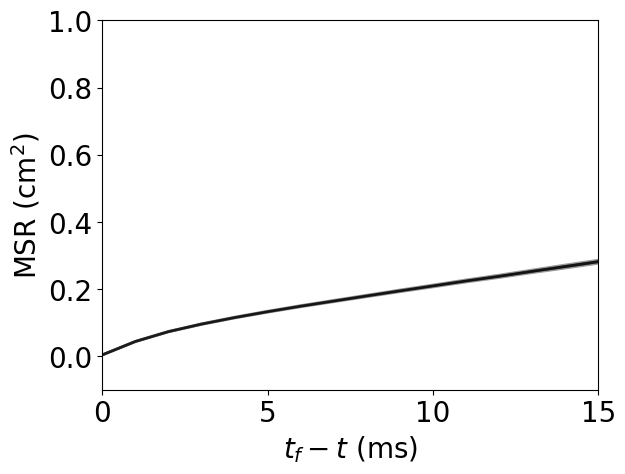

In [13]:
print(f"Does this appear to intersect at zero?")
c='k'
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,15])
plt.ylim([-.1,1])
plt.show()

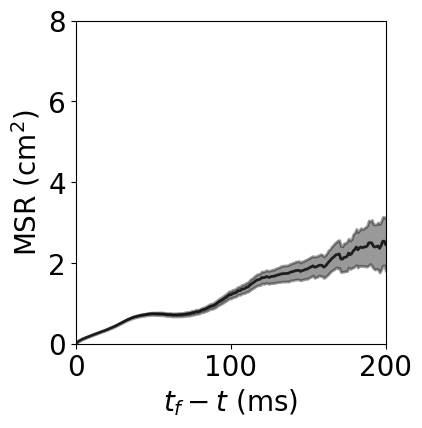

In [14]:
#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
ax.set_ylim([0,8])
plt.show()

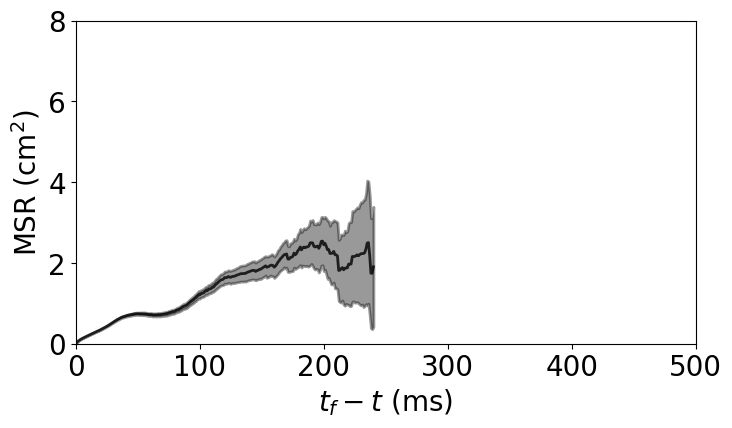

In [15]:
#plot expected
fig,ax=plt.subplots(figsize=(8,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,500])
ax.set_ylim([0,8])
plt.show()

In [16]:
#save msr as .csv
msr_dir_bootstrap=range_data_dir.replace('annihilation_range_timeseries.pkl','annihilation_msr.csv')
df_bootstrap.to_csv(msr_dir_bootstrap,index=False)
print(f"{msr_dir_bootstrap=}")

msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'


In [49]:
#######################
# Luo-Rudy
#######################
#WJ's data for LR model (200x200)
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# #my data for LR model (200x200) diffCoeff=0.001
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# #my data for LR model (200x200) diffCoeff=0.0005
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'


In [50]:
search_for_file()

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv


'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv'

In [2]:
#TODO: fit msr to analytical model solution to the affine oscillatory model, as before, except with period fixed
period=140 #ms

In [52]:
input_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv'
input_folder=os.path.dirname(input_dir)
fn_lst=[os.path.join(input_folder,x) for x in sorted(os.listdir(input_folder)) if x.find('_log.csv')!=-1]
print(f"found {len(fn_lst)} files comparable to {fn_lst[0]}")


found 324 files comparable to /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.0_log.csv
